In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mahakala as ma

from mahakala.grmhd.athenak import AthenakFluidModel
from mahakala.electrons import rlow_rhigh_model
from mahakala.transfer import synchrotron_coefficients, solve_specific_intensity, solve_specific_intensity_mine

jax is using the gpu


In [3]:
fname = '../data/torus.mhd_w_bcc.01500.athdf'
fname = 'torus.mhd_w_bcc.01980.athdf'

bhspin = 0.9
fluid_gamma = 13./9

fluid_model = AthenakFluidModel(fname, bhspin)

100%|██████████| 456/456 [00:00<00:00, 497.24it/s]


In [4]:
observing_frequency = 230.e9
Mass_scale = 1e+26
M_bh = 6.2e9 * 1.989e33
r_high = 40

inclination_in_degrees = 60
distance_in_rg = 1000

fov = 10
number_pixels_across = 160

s0 = ma.initialize_geodesics_at_camera(bhspin, inclination_in_degrees, distance_in_rg, -fov, fov, number_pixels_across)

In [5]:
S, final_dt = ma.geodesic_integrator(10000, s0, 40, 1e-4, bhspin)

In [6]:
fluid_scalars = fluid_model.get_fluid_scalars_from_geodesics(S)

100%|██████████| 456/456 [00:30<00:00, 14.72it/s]


In [7]:
# compute supplementary quantities from fluid data and scales

bsq = fluid_scalars['b'] * fluid_scalars['b']

beta = fluid_scalars['u'] * (fluid_gamma - 1.) / bsq / 0.5
beta.at[np.isnan(beta)].set(0.)

sigma = bsq / fluid_scalars['dens']
sigma.at[np.isnan(sigma)].set(0.)

Theta_e = rlow_rhigh_model(fluid_scalars['dens'], fluid_scalars['u'], beta, r_high=r_high)

local_nu = - fluid_scalars['kdotu'] * observing_frequency
gamma_inv_data = local_nu / observing_frequency

units = fluid_model.get_units(M_bh, Mass_scale)

Ne_in_cgs = units['Ne_unit'] * fluid_scalars['dens']
B_in_gauss = units['B_unit'] * fluid_scalars['b']
pitch_angle = fluid_scalars['pitch_angle']

In [8]:
from mahakala.transfer import synchrotron_coefficients, solve_specific_intensity, solve_specific_intensity_mine, solve_specific_intensity_newest, solve_specific_intensity_jax

In [9]:
emissivity, absorptivity = synchrotron_coefficients(Ne_in_cgs, Theta_e, B_in_gauss, pitch_angle, local_nu, invariant=False)

# apply sigma cutoff
sigma_cutoff = 100.

emissivity = emissivity.at[sigma > sigma_cutoff].set(0.)
absorptivity = absorptivity.at[sigma > sigma_cutoff].set(0.)

I_new, I_list = solve_specific_intensity_newest(emissivity, absorptivity, final_dt, local_nu, observing_frequency, units['L_unit'])

In [10]:
emissivity, absorptivity = synchrotron_coefficients(Ne_in_cgs, Theta_e, B_in_gauss, pitch_angle, local_nu, invariant=True, rescale_nu=1./observing_frequency)

# apply sigma cutoff
sigma_cutoff = 100.

emissivity = emissivity.at[sigma > sigma_cutoff].set(0.)
absorptivity = absorptivity.at[sigma > sigma_cutoff].set(0.)

I_new_jax, I_list_jax = solve_specific_intensity_jax(emissivity, absorptivity, final_dt, units['L_unit'])

In [11]:
print(np.allclose(I_new, I_new_jax), np.allclose(I_list, I_list_jax))

True True


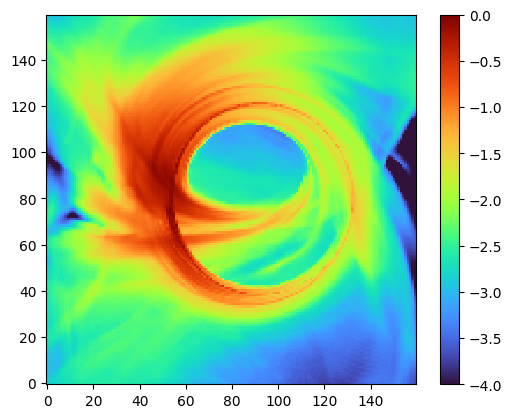

In [12]:
#im1 = plt.imshow(I_new.reshape((number_pixels_across, number_pixels_across)).T, origin='lower', cmap='turbo', vmin=0, vmax=0.002, interpolation='none')

pdata = I_new_jax.reshape((number_pixels_across, number_pixels_across)).T

#im1 = plt.imshow(pdata, origin='lower', cmap='turbo', vmin=0, vmax=0.002, interpolation='none')

pdata = pdata / np.max(pdata)
im1 = plt.imshow(np.log10(pdata), origin='lower', cmap='turbo', vmin=-4, vmax=0., interpolation='none')

plt.colorbar(im1)
plt.savefig('test.png')

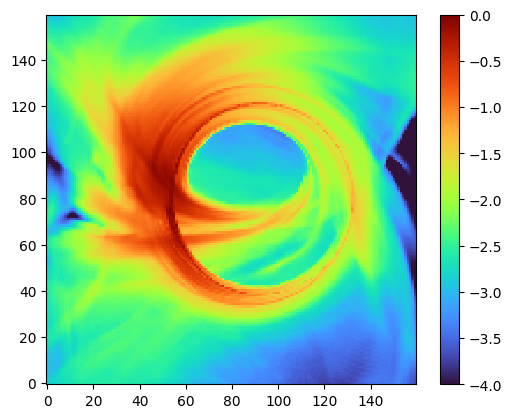

In [13]:
#im1 = plt.imshow(I_new.reshape((number_pixels_across, number_pixels_across)).T, origin='lower', cmap='turbo', vmin=0, vmax=0.002, interpolation='none')

pdata = I_new.reshape((number_pixels_across, number_pixels_across)).T
pdata = pdata / np.max(pdata)

im1 = plt.imshow(np.log10(pdata), origin='lower', cmap='turbo', vmin=-4, vmax=0., interpolation='none')
plt.colorbar(im1)
plt.savefig('test.png')